# Exercise Week 4
- Dave Schurtenberger
- Luca Kyburz
- Pascal Gansner
- Sofia Horlacher

In [415]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data import get_apple_5y, get_switzerland_temperature, compact_to_expanded


## 1. Simulate and analyze AR, MA, ARMA, ARIMA, SARIMA models
  - Generate time series data then compute ACF and PACF.
  - Determine model orders.
  - Compare empiric ACF and PACF with theoretical counterpart.
  - Estimate the model parameters from the generated data.


ACF and PACF Patterns for ARIMA and SARIMA Models

| **Model** | **ACF Pattern** ($\hat{\rho}_h$) | **PACF Pattern** ($\hat{\pi}_h$) | **Order Determination** |
|------------|----------------------------------|-----------------------------------|--------------------------|
| **AR($p$)** *(Stationary)* | Shows an infinite exponential (or sinusoidal) decay. | Exhibits a **cut-off** at lag $h = p$, where $\hat{\pi}_h \approx 0$ for $h > p$. | The AR order **$p$** is chosen as the lag where the PACF cuts off. |
| **MA($q$)** *(Stationary)* | Exhibits a **cut-off** at lag $h = q$, where $\hat{\rho}_h \approx 0$ for $h > q$. | Shows an infinite exponential (or sinusoidal) decay. | The MA order **$q$** is chosen as the lag where the ACF cuts off. |
| **ARMA($p, q$)** *(Stationary)* | Displays infinite exponential decay with a characteristic drop-off after lag $h > q$. | Displays infinite exponential decay with a characteristic drop-off after lag $h > p$. | Neither ACF nor PACF show a sharp cut-off. The values of **$p$** and **$q$** are inferred from the gradual drop-off behavior (favoring smaller orders). |
| **ARIMA($p, d, q$)** *(Non-stationary)* | The ACF of the **original** (non-stationary) series typically decays very slowly. After differencing $\nabla^d X_t$, the ACF follows ARMA($p, q$) behavior. | The PACF of the **original** series also decays slowly. After differencing $\nabla^d X_t$, the PACF follows ARMA($p, q$) behavior. | Determine **$d$** first (usually 1 or 2) to achieve stationarity. Then use the ACF and PACF of the differenced series to select **$p$** and **$q$**. |
| **SARIMA($p, d, q$)($P, D, Q$)\_s** *(Seasonal Non-stationary)* | The ACF and PACF of the original series show strong correlations at **seasonal lags** (multiples of $s$). Seasonal autocorrelations often remain high. | Same as ACF: clear patterns appear at multiples of $s$. | Apply **seasonal differencing** $\nabla_s^D$ first (often $D=1$) to remove seasonality, followed by non-seasonal differencing $\nabla^d$ if needed. Identify **$P$** and **$Q$** from ACF/PACF at seasonal lags (multiples of $s$), and **$p, q$** from low, non-seasonal lags. |


### 1.1 Autoregressive Model

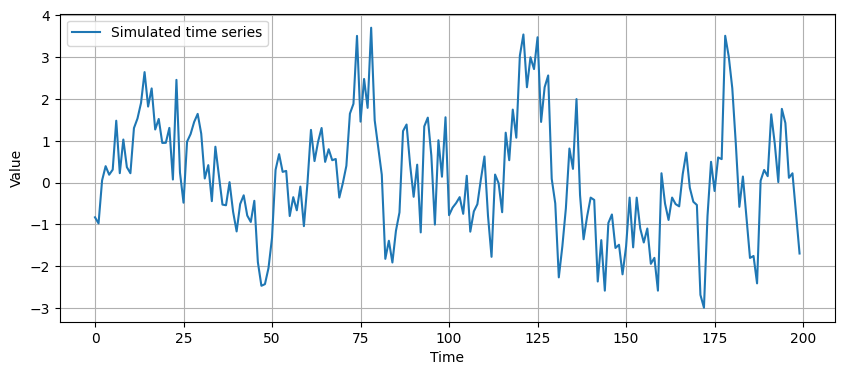

In [416]:
# AR(2) process coefficients
ar = np.array([1, -0.5, -0.25])
ma = np.array([1])

# Create ARMA process
arma_process = ArmaProcess(ar, ma)

# Generate sample
x_ar = arma_process.generate_sample(nsample=200)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x_ar, label='Simulated time series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


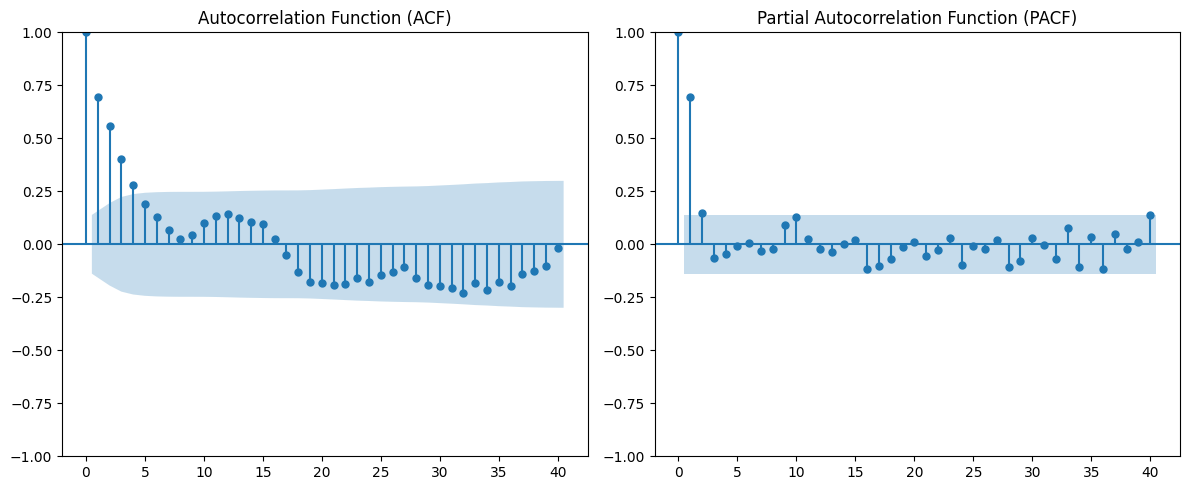

In [417]:
def plot_acf_and_pacf(x, lags=40):
    """Plot ACF and PACF of the time series x."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot ACF
    plot_acf(x, lags=lags, ax=ax[0])
    ax[0].set_title('Autocorrelation Function (ACF)')

    # Plot PACF
    plot_pacf(x, lags=lags, ax=ax[1], method='ywm')
    ax[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

plot_acf_and_pacf(x_ar)

- ACF decays sinusodial and gradually
- PACF decays quickly after lag 1
- The time series is stationary

=> Therefore should be an AR model

- PACF indicates that the time series has order 2
- Coefficients: $p_1 = 0.6$, $p_2 = 0.25$

In [418]:
result = adfuller(x_ar)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Stationary: {'Yes' if result[1] < 0.05 else 'No'}")

ADF Statistic: -4.612228228294896
p-value: 0.00012262952236680378
Stationary: Yes


In [419]:
model = AutoReg(x_ar, lags=2)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  200
Model:                     AutoReg(2)   Log Likelihood                -275.559
Method:               Conditional MLE   S.D. of innovations              0.973
Date:                Wed, 15 Oct 2025   AIC                            559.117
Time:                        16:32:58   BIC                            572.270
Sample:                             2   HQIC                           564.441
                                  200                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0333      0.070      0.478      0.633      -0.103       0.170
y.L1           0.5954      0.071      8.445      0.000       0.457       0.734
y.L2           0.1504      0.070      2.133      0.0

The summary does not indicate the best fit for an AR(2) model, even though the underlying process is indeed an AR(2) model, but the two coefficients are estimated with high confidence.

### 1.2 Moving Average

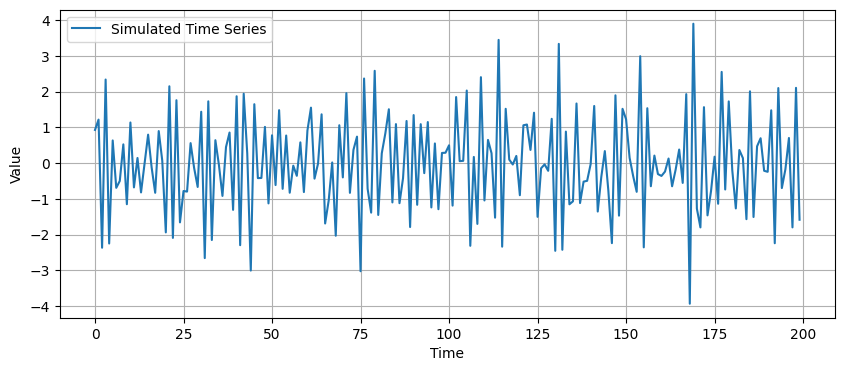

In [420]:
ar = np.array([1])
ma = np.array([1, -0.75, 0.5, -0.25])

# Create ARMA process
arma_process = ArmaProcess(ar, ma)

# Generate sample
x_ma = arma_process.generate_sample(nsample=200)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x_ma, label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


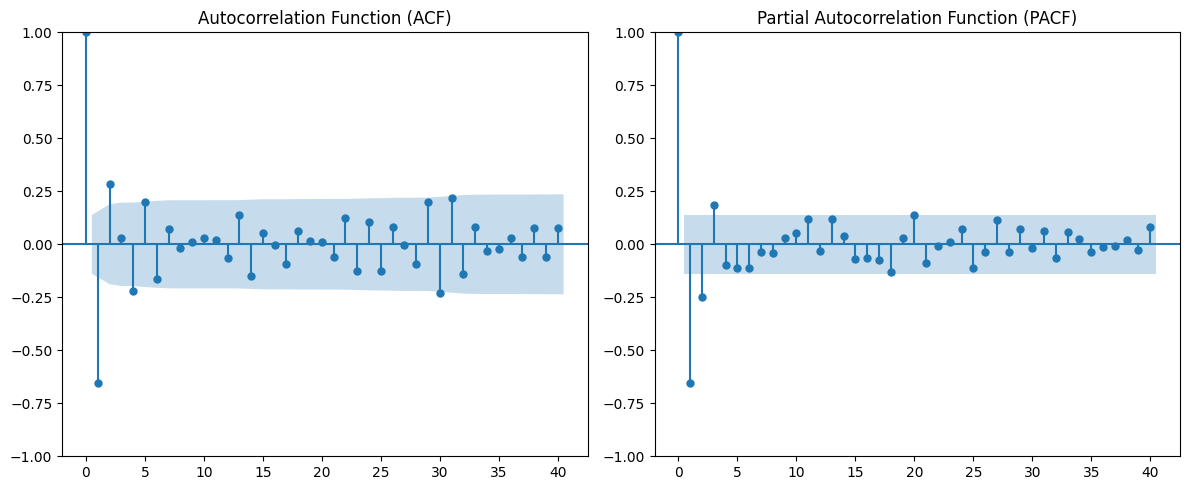

In [421]:
plot_acf_and_pacf(x_ma)

- ACF decays quickly after lag 1
- PACF decays quickly after lag 1
- The time series is stationary

=> As ACF and PACF both decay quickly could be an AR but actually is a MA model

- ACF indicates that the time series has order 3
- Coefficients: $p_1 = -0.75$, $p_2 = 0.25$, $p_3 = -0.25$

In [422]:
result = adfuller(x_ar)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Stationary: {'Yes' if result[1] < 0.05 else 'No'}")

ADF Statistic: -4.612228228294896
p-value: 0.00012262952236680378
Stationary: Yes


In [423]:
model = ARIMA(x_ma, order=(0, 0, 3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(0, 0, 3)   Log Likelihood                -282.241
Date:                Wed, 15 Oct 2025   AIC                            574.482
Time:                        16:32:58   BIC                            590.974
Sample:                             0   HQIC                           581.156
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0258      0.031     -0.820      0.412      -0.087       0.036
ma.L1         -0.8086      0.070    -11.516      0.000      -0.946      -0.671
ma.L2          0.5472      0.089      6.179      0.0

Same as before the summary does not indicate the best fit for an MA(3) model, even though the time series is indeed an MA(3) model, but the three coefficients are estimated with high confidence.

### 1.3 Autoregressive Moving Average

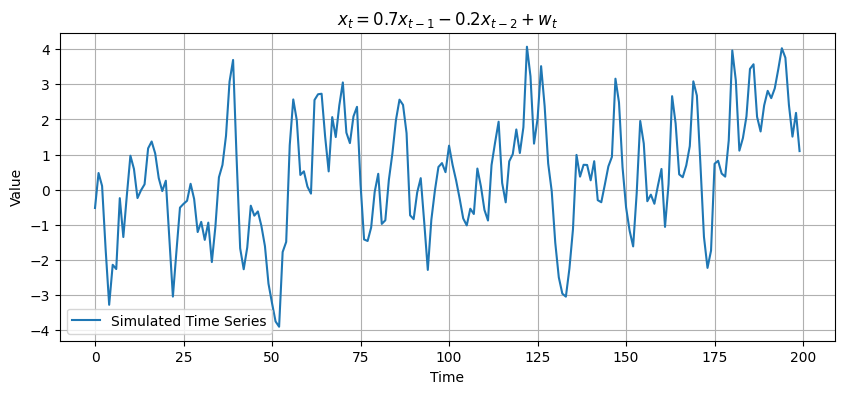

In [424]:
ar = np.array([1, -0.6]) 
ma = np.array([1, 0.5])

# Create ARMA process
arma_process = ArmaProcess(ar, ma)

# Generate sample
x_arma = arma_process.generate_sample(nsample=200)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x_arma, label='Simulated Time Series')
plt.title(r'$x_t = 0.7x_{t-1} - 0.2x_{t-2} + w_t$')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


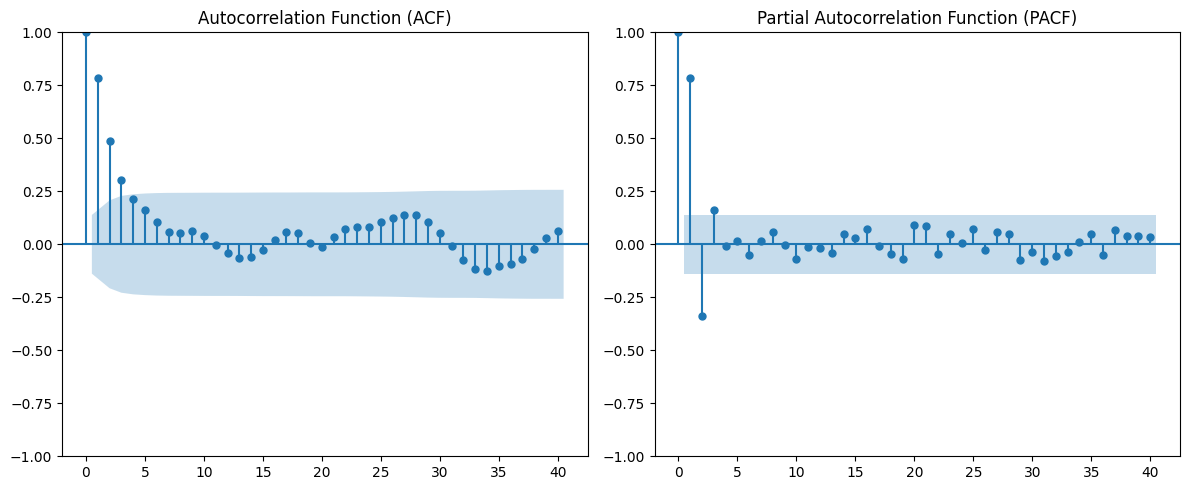

In [425]:
plot_acf_and_pacf(x_arma)

- ACF decays gradually and has sinusoidal decay
- PACF decays quickly after lag 1
- The time series is stationary

=> Could be an AR model based on the plots but actually is an ARMA

- ACF and PACF indicate that the time series has order (2,2) but actually is (1,1)
- Coefficients: $q_1 = 0.75$, $p_1 = 0.75$

In [426]:
result = adfuller(x_arma)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Stationary: {'Yes' if result[1] < 0.05 else 'No'}")

ADF Statistic: -4.951806117185205
p-value: 2.76200513366194e-05
Stationary: Yes


In [427]:
# Suppose your series is called `data` and you want MA(2)
model = ARIMA(x_arma, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -275.464
Date:                Wed, 15 Oct 2025   AIC                            558.928
Time:                        16:32:59   BIC                            572.121
Sample:                             0   HQIC                           564.267
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3997      0.275      1.452      0.147      -0.140       0.939
ar.L1          0.6319      0.068      9.226      0.000       0.498       0.766
ma.L1          0.4714      0.073      6.438      0.0

Same as before the summary does not indicate the best fit for an ARMA(1,1) model, even though the time series is indeed an ARMA(3) model, but the coefficients p and q are estimated with high confidence.

### 1.4 Autoregressive Integrated Moving Avergae

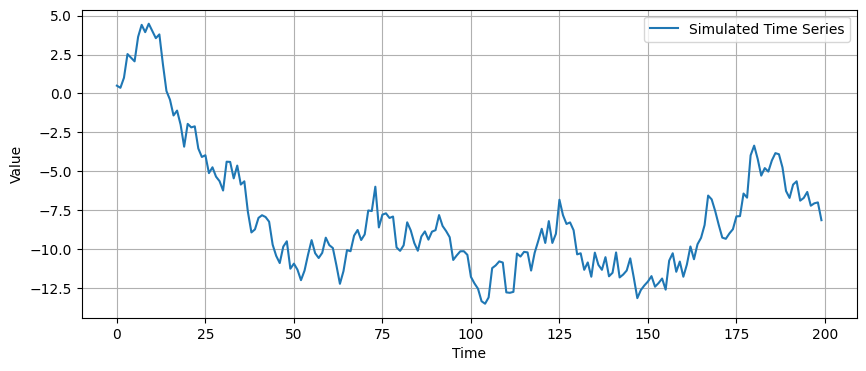

In [428]:
ar = np.array([1, -0.7, 0.2])
ma = np.array([1, -0.7, 0.2])

arma_process = ArmaProcess(ar, ma)

# Simulate the AR part (this gives the differenced series)
np.random.seed(42)
y_diff = arma_process.generate_sample(nsample=200)

# Integrate (undo differencing) to get ARIMA
x_arima = np.cumsum(y_diff)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x_arima, label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


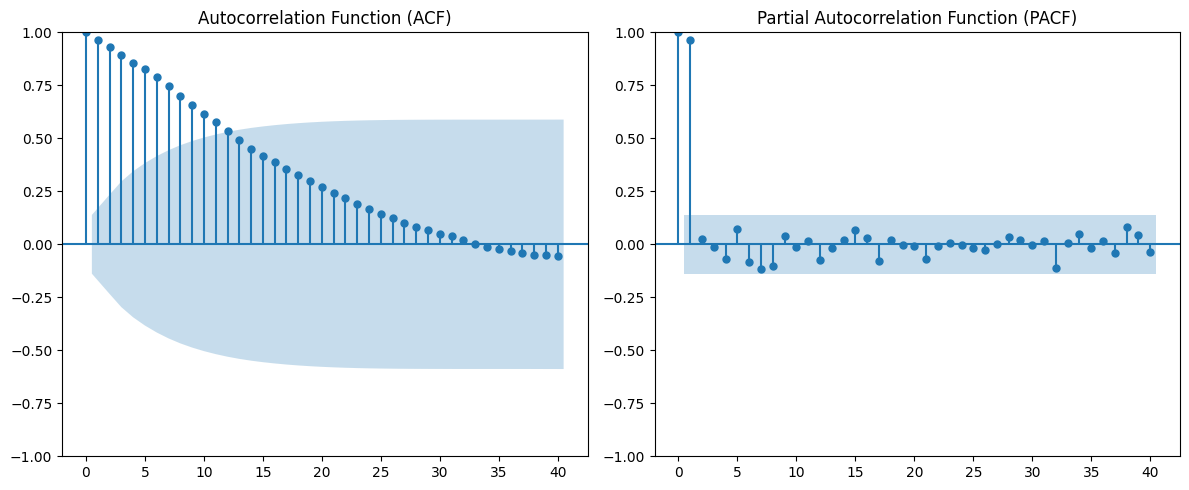

In [429]:
plot_acf_and_pacf(x_arima)

- ACF decays slowly
- PACF decays quickly after lag 1
- The time series is not stationary (based on time series plot and ACF)

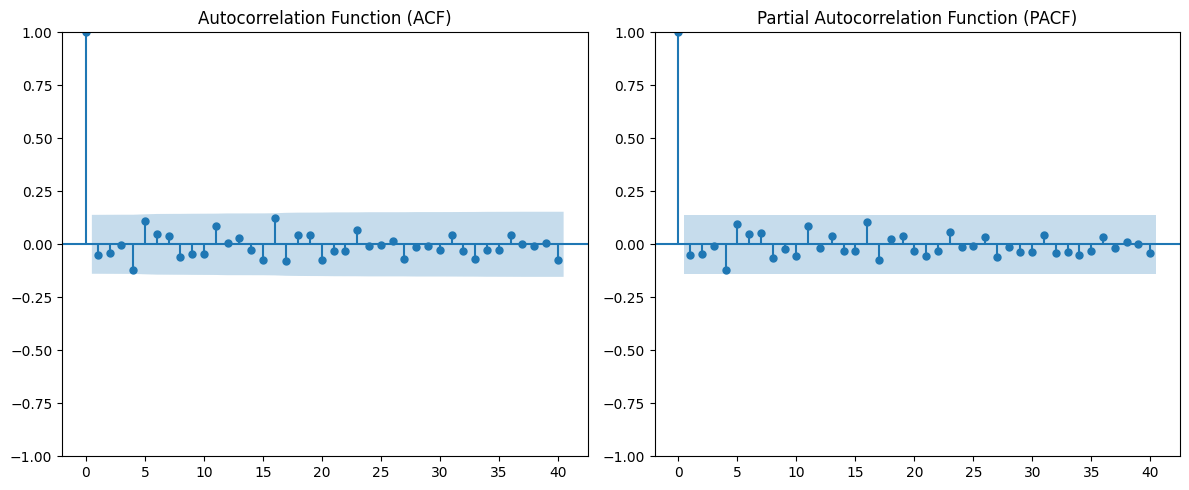

In [430]:
diff1_arima = np.diff(x_arima)
plot_acf_and_pacf(diff1_arima)


In [431]:
result = adfuller(diff1_arima)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Stationary: {'Yes' if result[1] < 0.05 else 'No'}")

ADF Statistic: -14.691774924143171
p-value: 3.0415339027297104e-27
Stationary: Yes



=> Because it is non stationary before differencing but statinoary afterwards and shows a clear drop off after lag 0 could be ARIMA

- order and coefficients can't be read from the plots

In [432]:
model = ARIMA(x_arima, order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -267.731
Date:                Wed, 15 Oct 2025   AIC                            541.461
Time:                        16:32:59   BIC                            551.341
Sample:                             0   HQIC                           545.460
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4893      0.849      0.577      0.564      -1.174       2.153
ma.L1         -0.5489      0.802     -0.684      0.494      -2.121       1.023
sigma2         0.8632      0.087      9.911      0.0

Same as before the summary does not indicate the best fit for an ARIMA(1,1,1) model, even though the time series is indeed an ARIMA(1,1,1) model, also the coefficients p and q are estimated with low confidence.

### 1.5 Seasonal Autoregressive Integrated Moving Avergae

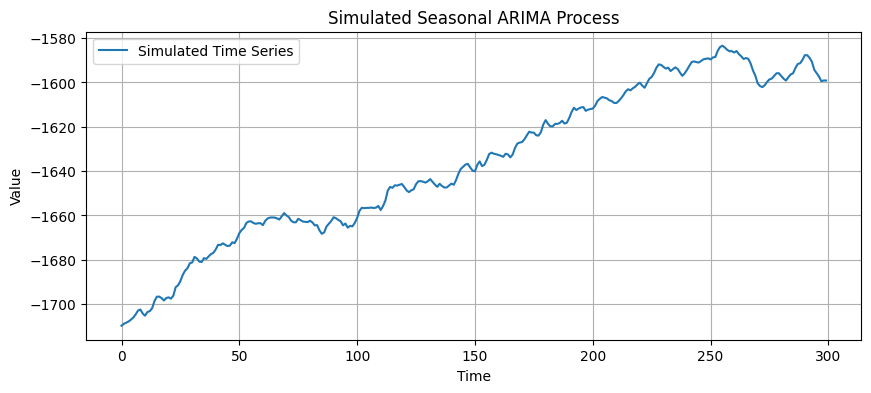

In [433]:
# Set random seed for reproducibility
np.random.seed(42)

# Define SARIMA parameters
order = (2, 1, 0)          # (p, d, q)
seasonal_order = (1, 0, 0, 12)  # (P, D, Q, s)
n = 300
w = np.random.normal(0, 1, n)
model = SARIMAX(w, order=order, seasonal_order=seasonal_order)
x_sarima = model.simulate(params=[0.7, -0.2, 0.5, 1], nsimulations=n)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x_sarima, label='Simulated Time Series')
plt.title('Simulated Seasonal ARIMA Process')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


- The time series shows seasonality and therefore is non stationary
- Differencing is required

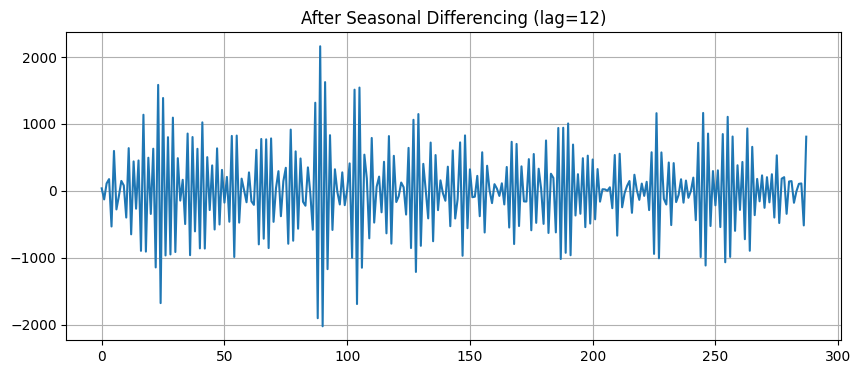

In [434]:
diff_seasonal = np.diff(x_sarima, n=12)
plt.figure(figsize=(10,4))
plt.plot(diff_seasonal)
plt.title("After Seasonal Differencing (lag=12)")
plt.grid(True)
plt.show()

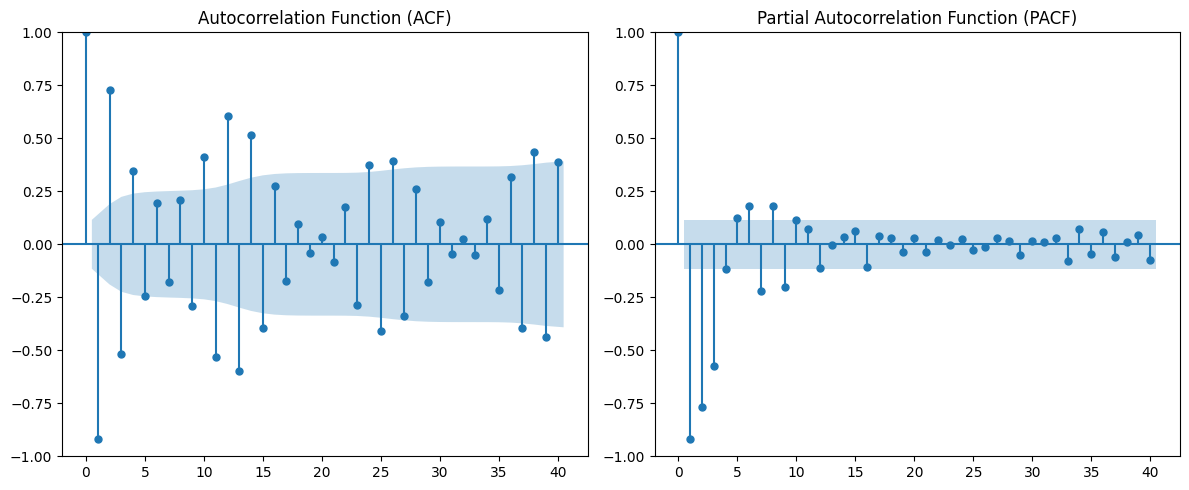

In [435]:
plot_acf_and_pacf(diff_seasonal)

- After removing seasonality with lag 12 the time series becomes stationary
- ACF decays sinusoidal
- PACF cuts off after lag 4

=> Therefore would assume a SARIMA model
- PACF indicates that SARIMA has order (4,0,1)
- Coefficients: ${p_1 = -0.9}$, ${p_2 = -0.8}$, ${p_3 = -0.7}$, ${p_4 = -0.4}$

In [436]:
result = adfuller(diff_seasonal)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Stationary: {'Yes' if result[1] < 0.05 else 'No'}")

ADF Statistic: -17.830091818987604
p-value: 3.1358621914356195e-30
Stationary: Yes


In [437]:
model = SARIMAX(x_sarima, order=(4,1,0), seasonal_order=(1,0,0,12))
model_fit = model.fit()

print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  300
Model:             SARIMAX(4, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -421.789
Date:                            Wed, 15 Oct 2025   AIC                            855.578
Time:                                    16:33:00   BIC                            877.781
Sample:                                         0   HQIC                           864.465
                                            - 300                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5823      0.062      9.426      0.000       0.461       0.703
ar.L2         -0.1286      0.066   

Same as before the summary does not indicate the best fit for an SARIMA(4,0,1) model. The model is actually also an SARIMA(2,1,0) model with (1,0,0,12) seasonality.

## 2. Model real-world time series
- Is differencing required?
- Determine model order from ACF and PACF (review this summary).
- Estimate the model parameters.

### 2.1 Apple Stock Prices

In [438]:
x_apple = get_apple_5y()

c:\Users\paeschu\source\repos\time\notebooks\data.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', period='5y')
[*********************100%***********************]  1 of 1 completed


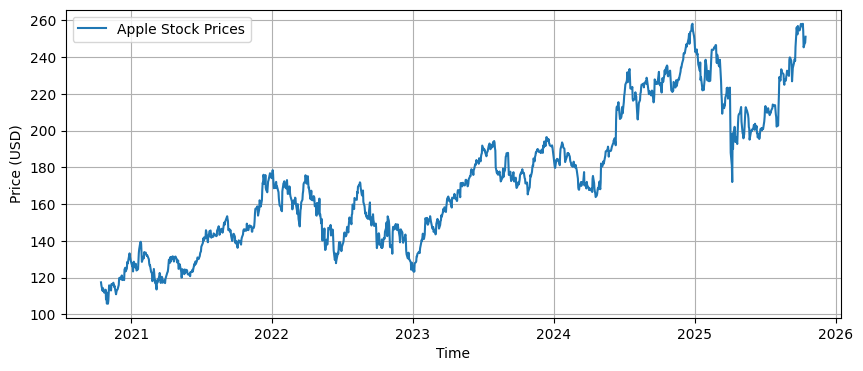

In [439]:
# Plot
plt.figure(figsize=(10, 4))
plt.plot(x_apple.index,x_apple['Close'], label='Apple Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

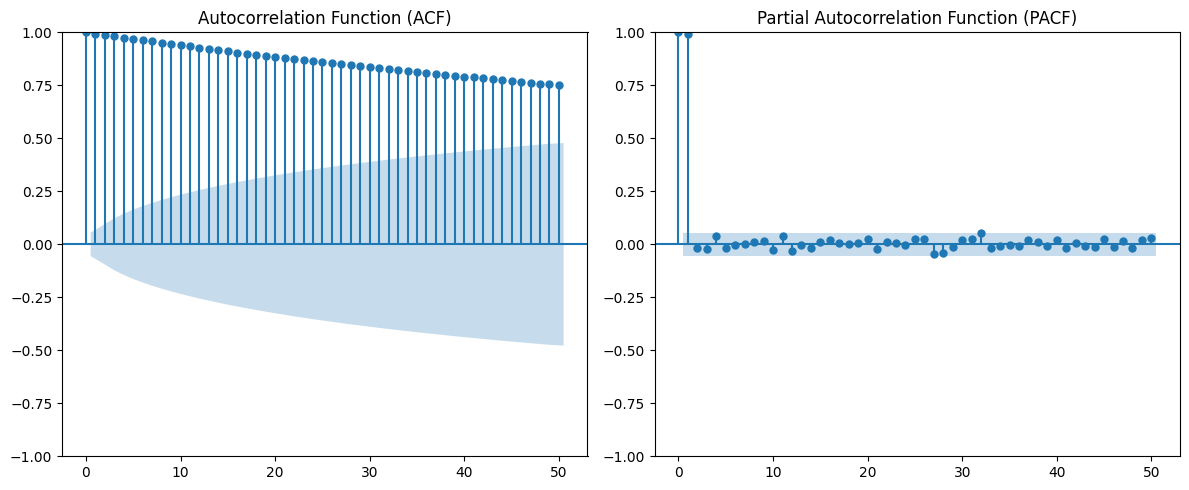

In [440]:
plot_acf_and_pacf(x_apple['Close'], lags=50)

Based on rule 1 we need differencing as the the autocorrelation plot is positive to a high number of lags (50).

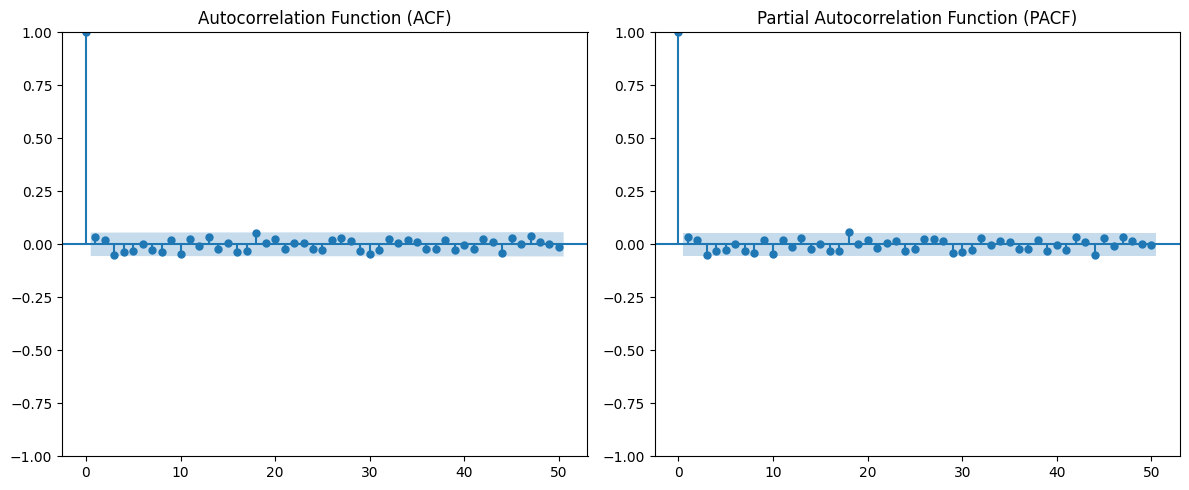

In [441]:
diff1_apple = x_apple['Close'].diff().dropna()
plot_acf_and_pacf(diff1_apple, lags=50)

Based on the ACF and PACF plot of the differenced time series I would set the order of the model to (0,1,0). Both plots do not show a significant lag.

In [442]:
model = ARIMA(x_apple['Close'], order=(0,1,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1256
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3186.997
Date:                Wed, 15 Oct 2025   AIC                           6375.994
Time:                        16:33:01   BIC                           6381.129
Sample:                             0   HQIC                          6377.924
                               - 1256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         9.4027      0.174     54.184      0.000       9.063       9.743
Ljung-Box (L1) (Q):                   1.54   Jarque-Bera (JB):              2832.23
Prob(Q):                              0.21   Pr

c:\Users\paeschu\source\repos\time\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\paeschu\source\repos\time\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\paeschu\source\repos\time\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### 2.2 Switzerland Temperature

In [443]:
x_temp = get_switzerland_temperature()

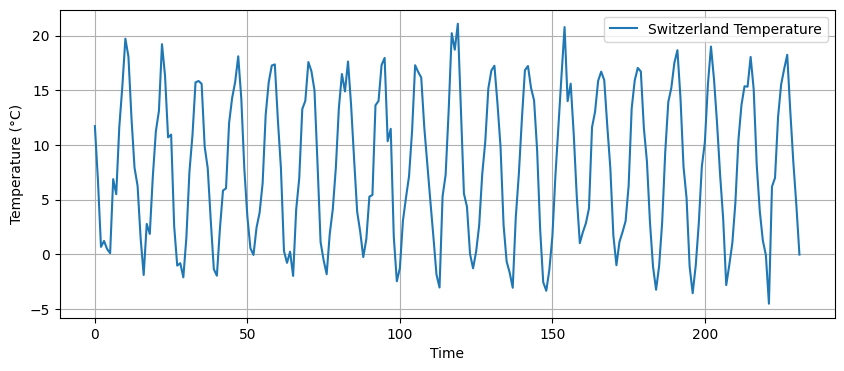

In [444]:
plt.figure(figsize=(10, 4))
plt.plot(x_temp['AverageTemperature'], label='Switzerland Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

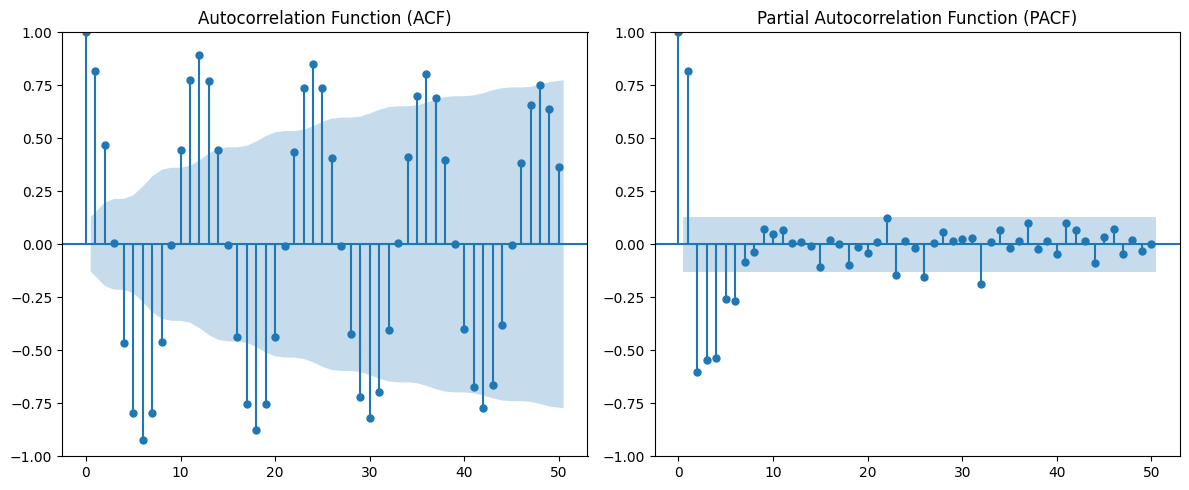

In [445]:
plot_acf_and_pacf(x_temp['AverageTemperature'], lags=50)

- The time series shows seasonality and therefore is not stationary
- Differencing is required
- As we are looking at highly sesonal data (monthly temperature) the seasonality has lag 12

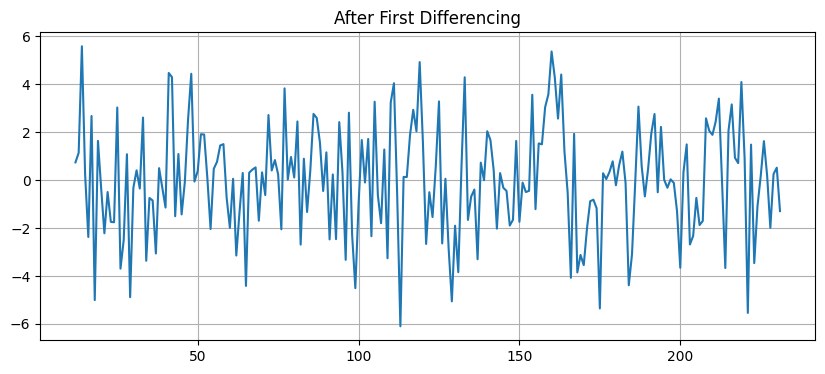

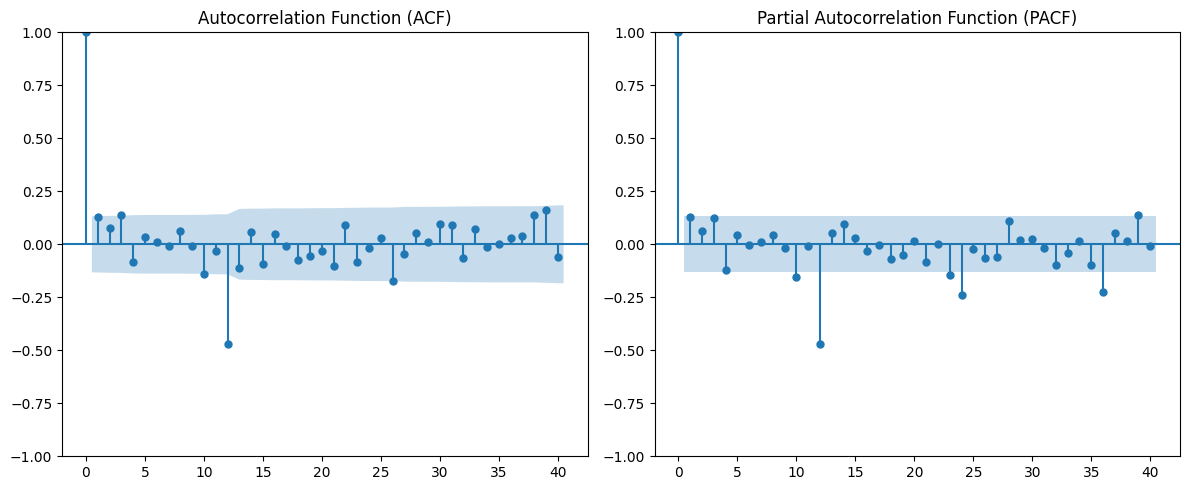

In [446]:
diff1_temp = x_temp['AverageTemperature'].diff(12).dropna()
plt.figure(figsize=(10,4))
plt.plot(diff1_temp)
plt.title("After First Differencing")
plt.grid(True)
plot_acf_and_pacf(diff1_temp)

- Time series is not stationary
- Based on the ACF and PACF plot the order is AR(1), MA(1) = (1,1,0,12)

In [447]:
model = ARIMA(x_temp['AverageTemperature'], order=(0,0,0), seasonal_order=(1,1,0,12))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                  232
Model:             ARIMA(1, 1, 0, 12)   Log Likelihood                -463.158
Date:                Wed, 15 Oct 2025   AIC                            930.316
Time:                        16:33:02   BIC                            937.104
Sample:                             0   HQIC                           933.057
                                - 232                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5052      0.062     -8.137      0.000      -0.627      -0.383
sigma2         3.8828      0.372     10.430      0.000       3.153       4.612
Ljung-Box (L1) (Q):                   3.55   Jarque-

### 2.3 Energy Consumption

100%|██████████| 50/50 [00:00<00:00, 1258.92it/s]


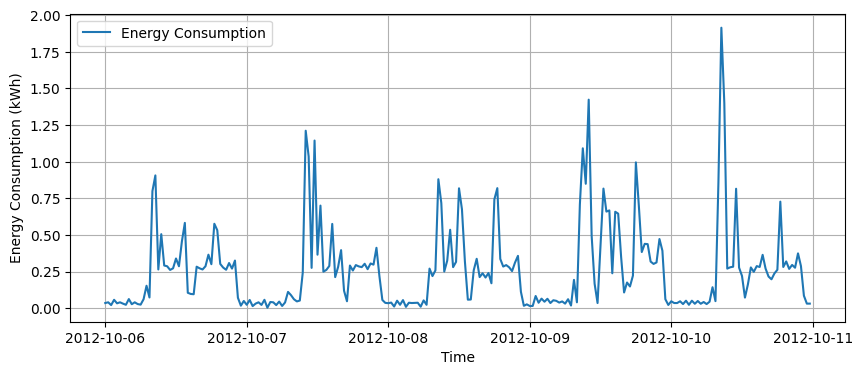

In [448]:
block_df = pd.read_parquet("01_Exercise/data/london_smart_meters/preprocessed/london_smart_meters_merged_block_0-7.parquet")
exp_block_df = compact_to_expanded(block_df[block_df.file=="block_7"], timeseries_col = 'energy_consumption', static_cols = [], time_varying_cols = [], ts_identifier = "LCLid")
# Use the same data as in the notebook from exercise 1
x_energy_consumption = exp_block_df[exp_block_df.LCLid=="MAC000193"].set_index("timestamp")
x_energy_consumption.ffill()
# Analyze a short window of days for visibility
window =  slice("2012-10-06", "2012-10-10")
x_energy_consumption = x_energy_consumption[window]

plt.figure(figsize=(10, 4))
plt.plot(x_energy_consumption['energy_consumption'], label='Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)

- The time series shows seasonality and therefore is not stationary
- Differencing is required
- As we are looking at highly sesonal data (daily energy consumption data points at every 30min) the seasonality has lag 48

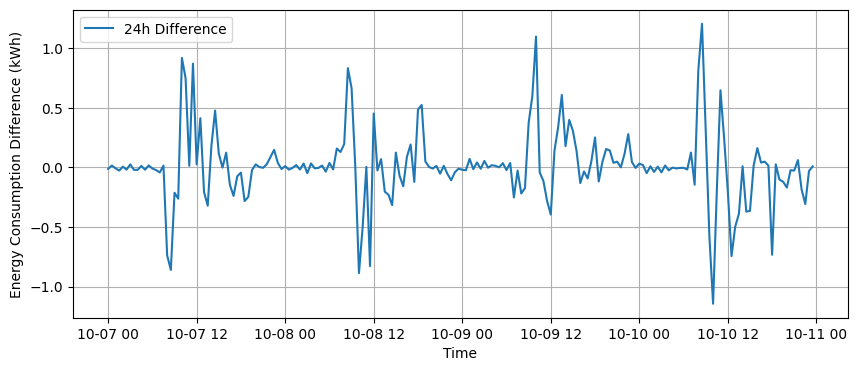

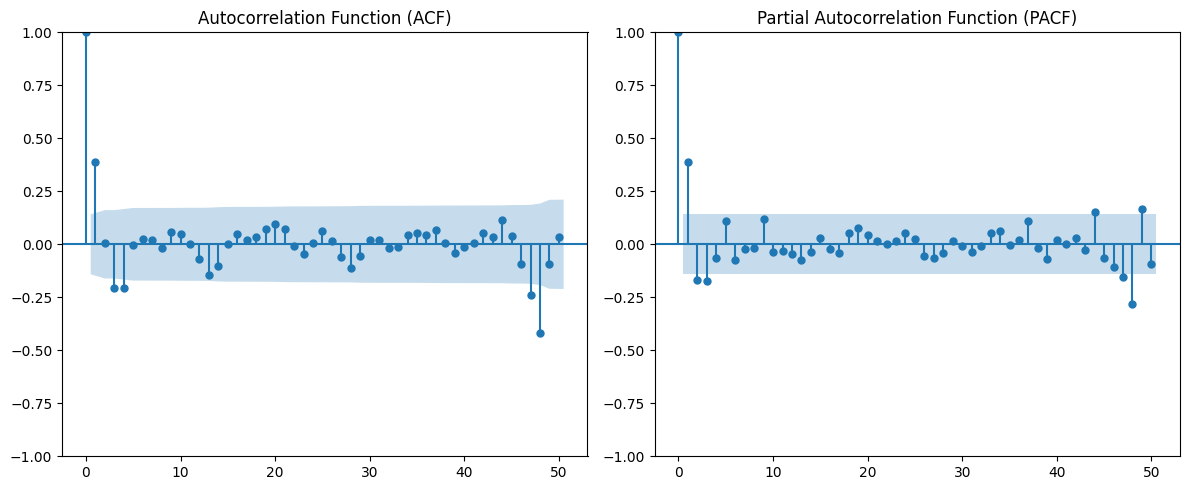

In [449]:
diff48_energy = x_energy_consumption['energy_consumption'].diff(48).dropna()
plt.figure(figsize=(10,4))
plt.plot(diff48_energy, label='24h Difference')
plt.xlabel('Time')
plt.ylabel('Energy Consumption Difference (kWh)')
plt.legend()
plt.grid(True)
plot_acf_and_pacf(diff48_energy, lags=50)

- The time series is now stationary
- Based on the plot the time sseries has the order (3, 1, 0, 48)

In [450]:
result = adfuller(diff48_energy)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Stationary: {'Yes' if result[1] < 0.05 else 'No'}")

ADF Statistic: -8.874967241263445
p-value: 1.3657865218536355e-14
Stationary: Yes


In [451]:
model = SARIMAX(x_energy_consumption['energy_consumption'], order=(3,1,0), seasonal_order=(1,1,0,48))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\paeschu\source\repos\time\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
c:\Users\paeschu\source\repos\time\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                 energy_consumption   No. Observations:                  240
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 48)   Log Likelihood                 -20.512
Date:                            Wed, 15 Oct 2025   AIC                             51.024
Time:                                    16:33:11   BIC                             67.286
Sample:                                10-06-2012   HQIC                            57.611
                                     - 10-10-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2809      0.056     -4.987      0.000      -0.391      -0.170
ar.L2         -0.2803      0.051   

The summary does indicate a very good fit of the data based on the log likelihood and the probability of the different AR and MA parameters.